# Datamining Final Project

Ben Heinze, Braxton McCormack, Michael Hagin

---

### Information
- [Brown Corpus (section 1.3)](https://www.nltk.org/book/ch02.html)
- [Extracting PDF Data](https://www.freecodecamp.org/news/extract-data-from-pdf-files-with-python/)
- [Stemming Help](https://www.geeksforgeeks.org/python-stemming-words-with-nltk/)
- [PDF for Testing](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10198233)

# Part 2: Code Analysis

---

## Setup

---
`pip install pdfquery` - Necessary to parse pdfs \
`pip install nltk` - Install the necessary natural-language-processing module.

Before starting any preprocessing, we need to gather a set of all adjectives and all verbs so we can extract them from the academic papers. To do this, we used a corpus created by Brown University. The corpus was collected from a large variety of sources from 1964 and was the first of its kind to contain one million words. We may need to choose another source that is more updated with modern diction. That will be an easy substitute.

In [1]:
import os
import nltk
from pdfquery import PDFQuery
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import brown
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

nltk.download('brown') #browns corpus
nltk.download('punkt') #got an error without this
nltk.download('wordnet') 

# Extract adjectives from the Brown corpus
adjectives = [word.lower() for word, pos in nltk.corpus.brown.tagged_words() if pos.startswith('JJ')]
# Extract verbs from the Brown corpus
verbs = [word.lower() for word, pos in nltk.corpus.brown.tagged_words() if pos.startswith('VB')]

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Ben\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ben\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ben\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preprocessing: 

---

Extract adjectives and verbs from text (Discover it if actually parses full text or not)

In [2]:
'''
Purpose:
    Extracts all verbs and adjectives from a pdf and returns them as dictionaries, with the key being the stemmed word and the value being the frequency
    Separated by part-of-speech in case individual analysis should be performed
Parameters:
    filename: the name of the file that exists in 'data' directory. Must include the extension.
return:
    df: dataframe that contains the columns 'word', 'frequency', 'boole
'''

def extract_pdf_info(path):
    pdf = PDFQuery(path)
    pdf.load()
    # Use CSS-like selectors to locate the elements
    text_elements = pdf.pq('LTTextLineHorizontal')
    # Extract the text from the elements
    text = [t.text for t in text_elements]
    parsed_adjectives = {}# stores adjectives found in the texts
    parsed_verbs = {}     # stores verbs found in the texts
    stemmer = PorterStemmer() 
    
    # sort tokens by part-of-speech (verb or adj)
    for line in text:
        tokens = nltk.word_tokenize(line) # tokenizes line
        for token in tokens:
            # if adjective, add to parsed_adj list.
            if token in adjectives:
                t = stemmer.stem(token)
                if t in parsed_adjectives:
                    parsed_adjectives[t] += 1
                else:
                    parsed_adjectives[t] = 1
            # if verb, add to parsed_verb list.
            elif token in verbs:
                t = stemmer.stem(token)
                if t in parsed_verbs:
                    parsed_verbs[t] += 1
                else:
                    parsed_verbs[t] = 1

    # Combines verb and dictionary list
    combined_dict = {'word': list(parsed_verbs.keys()) + list(parsed_adjectives.keys()),
                 'frequency': list(parsed_verbs.values()) + list(parsed_adjectives.values())}
    
    # Add columns for "adjective" and "verb"
    isAdj = []
    isVerb =  []
    for word in combined_dict['word']:
        # sets boolean values for if the word is adj or verb
        if word in parsed_adjectives:
            isAdj.append(True)
        else:
            isAdj.append(False)
        if word in parsed_verbs:
            isVerb.append(True)
        else:
            isVerb.append(False)
    combined_dict['isAdj'] = isAdj
    combined_dict['isVerb'] = isVerb
    
    df = pd.DataFrame(combined_dict)
    # sums frequencies of words that are both adjectives and verbs, then keeps once row
    df = df.groupby('word', as_index=False).agg({'frequency': 'sum', 'isAdj': 'first', 'isVerb': 'first'})

    # normalize frequency in paper
    min_value = df['frequency'].min()
    max_value = df['frequency'].max()
    df['normalized_frequency'] = (df['frequency'] - min_value) / (max_value - min_value)
    
    return df

Gather data from every file in specific folder named after the year.

In [3]:
# Puts every file path into a list
def gather_year_paper_names(year):
    directory_path = 'data/'+str(year)+"/"
    file_strings = []
    for filename in os.listdir(directory_path):
        filepath = os.path.join(directory_path, filename)
        if os.path.isfile(filepath):  # Check if it's a file
            file_strings.append(filepath)
    return file_strings

In [4]:
# Merges two dataframes together
def merge_dataframes(df1, df2):
    # merge
    merged_df = pd.merge(df1, df2, on='word', how='outer', suffixes=('_df1', '_df2'))

    # fill 0's in case one dataset has words that the other does not
    merged_df['frequency_df1'] = merged_df['frequency_df1'].fillna(0)
    merged_df['frequency_df2'] = merged_df['frequency_df2'].fillna(0)
    merged_df['normalized_frequency_df1'] = merged_df['normalized_frequency_df1'].fillna(0)
    merged_df['normalized_frequency_df2'] = merged_df['normalized_frequency_df2'].fillna(0)
    
    # sum frequencies
    merged_df['frequency'] = merged_df['frequency_df1'] + merged_df['frequency_df2']
    merged_df['normalized_frequency'] = merged_df['normalized_frequency_df1'] + merged_df['normalized_frequency_df2']
    
    # Set isVerb/isAdj to True if either df1 is true or df2 is true
    merged_df.loc[(merged_df['isVerb_df1'] == True ) | (merged_df['isVerb_df2'] == True), 'isVerb'] = True
    merged_df.loc[(merged_df['isAdj_df1'] == True ) | (merged_df['isAdj_df2'] == True), 'isAdj'] = True
    
    # fill NaNs in isVerb/isAdj columns with False
    merged_df['isVerb'] = merged_df['isVerb'].fillna(False)
    merged_df['isAdj'] = merged_df['isAdj'].fillna(False)
    
    # drop intermediate columns
    merged_df = merged_df.drop(['isVerb_df1', 'isVerb_df2','isAdj_df1', 'isAdj_df2', 'frequency_df1', 'frequency_df2',
                                'normalized_frequency_df1', 'normalized_frequency_df2'], axis=1)
    return merged_df

In [5]:
'''
Purpose:
Parameters:
    year: Selects which folder to open up. The papers are categorized in folders named after the year they were published.
return:
    result: a dataframe of all the stemmed adjectives/verbs and their count
'''
def combine_yearly_diction(year):
    # Gather list of all file paths in the selected folder (folders are named after the year of publication)
    annual_paper_paths = gather_year_paper_names(year)
    # Store result dataframe
    result = None

    # Merge every paper into one dataframe
    for i, paper_path in enumerate(annual_paper_paths):
        if i == 0:
            result = extract_pdf_info(paper_path) #get first dataframe
        else:            
            temp_dataframe = extract_pdf_info(paper_path)
            result = merge_dataframes(result, temp_dataframe)
    return result

In [6]:
tf_2018 = combine_yearly_diction(2018)
tf_2018 = tf_2018.sort_values(by='frequency', ascending=False)
tf_2018

,word,frequency,normalized_frequency,isVerb,isAdj
187,can,1280.0,9.004849,True,False
1638,use,1096.0,7.476755,True,True
1357,set,1022.0,6.728403,True,False
1545,time,920.0,5.602873,True,False
635,function,913.0,6.499865,True,True
...,...,...,...,...,...
952,mistak,1.0,0.000000,True,False
953,mitig,1.0,0.000000,True,False
959,modest,1.0,0.000000,False,True
971,mute,1.0,0.000000,False,True


In [7]:
tf_2019 = combine_yearly_diction(2019)
tf_2019 = tf_2019.sort_values(by='frequency', ascending=False)
tf_2019

,word,frequency,normalized_frequency,isVerb,isAdj
178,can,1308.0,10.967114,True,False
1301,set,1303.0,10.196340,True,False
1504,time,1094.0,6.784846,True,True
1435,such,1005.0,7.912691,False,True
1602,use,961.0,7.599893,True,True
...,...,...,...,...,...
744,inflat,1.0,0.000000,True,False
1320,shrank,1.0,0.000000,True,False
39,affili,1.0,0.000000,True,False
40,afford,1.0,0.000000,True,False


In [8]:
tf_2020 = combine_yearly_diction(2020)
tf_2020 = tf_2020.sort_values(by='frequency', ascending=False)
tf_2020

,word,frequency,normalized_frequency,isVerb,isAdj
155,can,716.0,4.314304,True,False
1399,use,651.0,3.508090,True,True
1147,set,563.0,3.338651,True,False
1318,then,450.0,2.416923,False,True
1265,such,386.0,2.068163,False,True
...,...,...,...,...,...
909,perman,1.0,0.000000,False,True
906,peopl,1.0,0.000000,True,False
904,pend,1.0,0.000000,False,True
903,peer,1.0,0.000000,True,False


In [9]:
tf_2021 = combine_yearly_diction(2021)
tf_2021 = tf_2021.sort_values(by='frequency', ascending=False)
tf_2021

,word,frequency,normalized_frequency,isVerb,isAdj
206,can,1703.0,13.265422,True,False
1394,set,1557.0,10.696660,True,False
1531,such,1302.0,9.834941,False,True
1718,use,1165.0,9.584493,True,True
632,follow,998.0,7.711435,True,False
...,...,...,...,...,...
636,forbidden,1.0,0.000000,True,False
1358,salient,1.0,0.000000,False,True
647,frequent,1.0,0.000000,False,True
649,friendli,1.0,0.000000,False,True


In [10]:
tf_2022 = combine_yearly_diction(2022)
tf_2022 = tf_2022.sort_values(by='frequency', ascending=False)
tf_2022

,word,frequency,normalized_frequency,isVerb,isAdj
180,can,1979.0,13.241359,True,False
1604,use,1660.0,11.322154,True,True
618,function,1534.0,9.615596,True,True
1443,such,1460.0,10.550819,False,True
1313,set,1439.0,10.133399,True,False
...,...,...,...,...,...
783,invalu,1.0,0.000000,False,True
791,irregular,1.0,0.000000,False,True
793,irrevoc,1.0,0.000000,False,True
798,jump,1.0,0.000000,True,False


In [11]:
tf_2023 = combine_yearly_diction(2023)
tf_2023 = tf_2023.sort_values(by='frequency', ascending=False)
tf_2023

,word,frequency,normalized_frequency,isVerb,isAdj
184,can,2234.0,13.941396,True,False
1409,set,1655.0,10.472091,True,False
1550,such,1577.0,9.894624,False,True
1735,use,1461.0,9.216799,True,True
1626,time,1439.0,7.516548,True,False
...,...,...,...,...,...
987,mislead,1.0,0.000000,False,True
993,modern,1.0,0.000000,False,True
1005,multidimension,1.0,0.000000,False,True
1011,myriad,1.0,0.000000,False,True


In [12]:
tf_2024 = combine_yearly_diction(2024)
tf_2024 = tf_2024.sort_values(by='frequency', ascending=False)
tf_2024

,word,frequency,normalized_frequency,isVerb,isAdj
153,can,480.0,3.593158,True,False
1267,use,397.0,2.937839,True,True
1053,set,380.0,3.233828,True,False
1198,then,322.0,2.483230,False,True
1159,such,321.0,2.382103,False,True
...,...,...,...,...,...
749,modular,1.0,0.000000,False,True
746,modern,1.0,0.000000,False,True
744,mix,1.0,0.000000,True,False
743,miss,1.0,0.000000,True,False


In [83]:
def plot_combined_graphs(df1, df2, df1Year, df2Year):
    # Graph 1
    # Perform an outer join on 'word'
    merged_data = df1.merge(df2, on='word', how='outer', suffixes=('_2019', '_2018'))

    # Fill NaN values with zeros
    merged_data['normalized_frequency_2019'].fillna(0, inplace=True)
    merged_data['normalized_frequency_2018'].fillna(0, inplace=True)

    # Calculate the difference in normalized frequency between df1 and df2
    merged_data['difference'] = merged_data['normalized_frequency_2019'] - merged_data['normalized_frequency_2018']
    plt.figure(figsize=(14, 14))
    # Plot graph 1
    plt.subplot(2, 1, 1)  # Create subplot 1
    plt.scatter(merged_data['frequency_2019'], merged_data['difference'], color='purple',alpha =.6)
    # Label each point with the corresponding word
    for i, word in enumerate(merged_data['word']):
        plt.text(merged_data['frequency_2019'].iloc[i], merged_data['difference'].iloc[i], word, fontsize=9, ha='left', va='bottom')

    plt.xlabel('Term Frequency')
    plt.ylabel(f'Difference in Normalized Frequency ({df1Year} - {df2Year})')
    plt.title(f'Difference in Normalized Frequency between {df1Year} and {df2Year}')
    plt.grid(True)

    # Graph 2
    # Perform an outer merge on 'word'
    merged_data = df1.merge(df2, on='word', how='outer', suffixes=('_2019', '_2018'))

    # Filter out rows where one of the normalized frequency columns is NaN
    words_only_in_df1 = merged_data[merged_data['normalized_frequency_2019'].notna() & merged_data['normalized_frequency_2018'].isna()]
    words_only_in_df2 = merged_data[merged_data['normalized_frequency_2018'].notna() & merged_data['normalized_frequency_2019'].isna()]

    # Plot the words only in df1
    plt.subplot(2, 1, 2)  # Create subplot 2
    plt.scatter(words_only_in_df1['frequency_2019'], words_only_in_df1['normalized_frequency_2019'], color='red', label=f'Only in {df1Year}')

    # Plot the words only in df2
    plt.scatter(words_only_in_df2['frequency_2018'], words_only_in_df2['normalized_frequency_2018'], color='blue', label=f'Only in {df2Year}')

    # Annotate each point with its corresponding word
    for word, x, y in zip(words_only_in_df1['word'], words_only_in_df1['frequency_2019'], words_only_in_df1['normalized_frequency_2019']):
        plt.annotate(word, (x, y), textcoords="offset points", xytext=(5,10), ha='left', va='bottom')

    for word, x, y in zip(words_only_in_df2['word'], words_only_in_df2['frequency_2018'], words_only_in_df2['normalized_frequency_2018']):
        plt.annotate(word, (x, y), textcoords="offset points", xytext=(5,10), ha='left', va='bottom')

    plt.xlabel('Term Frequency')
    plt.ylabel('Normalized Frequency')
    plt.title('Words Only in One Dataset')
    plt.legend()
    plt.grid(True)

    # Adjust layout and spacing
    plt.tight_layout(pad=4.0, h_pad=4.0)
    plt.savefig(f"graphs/{df1Year}_{df2Year}.png", dpi=330)
    # Show plot
    plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

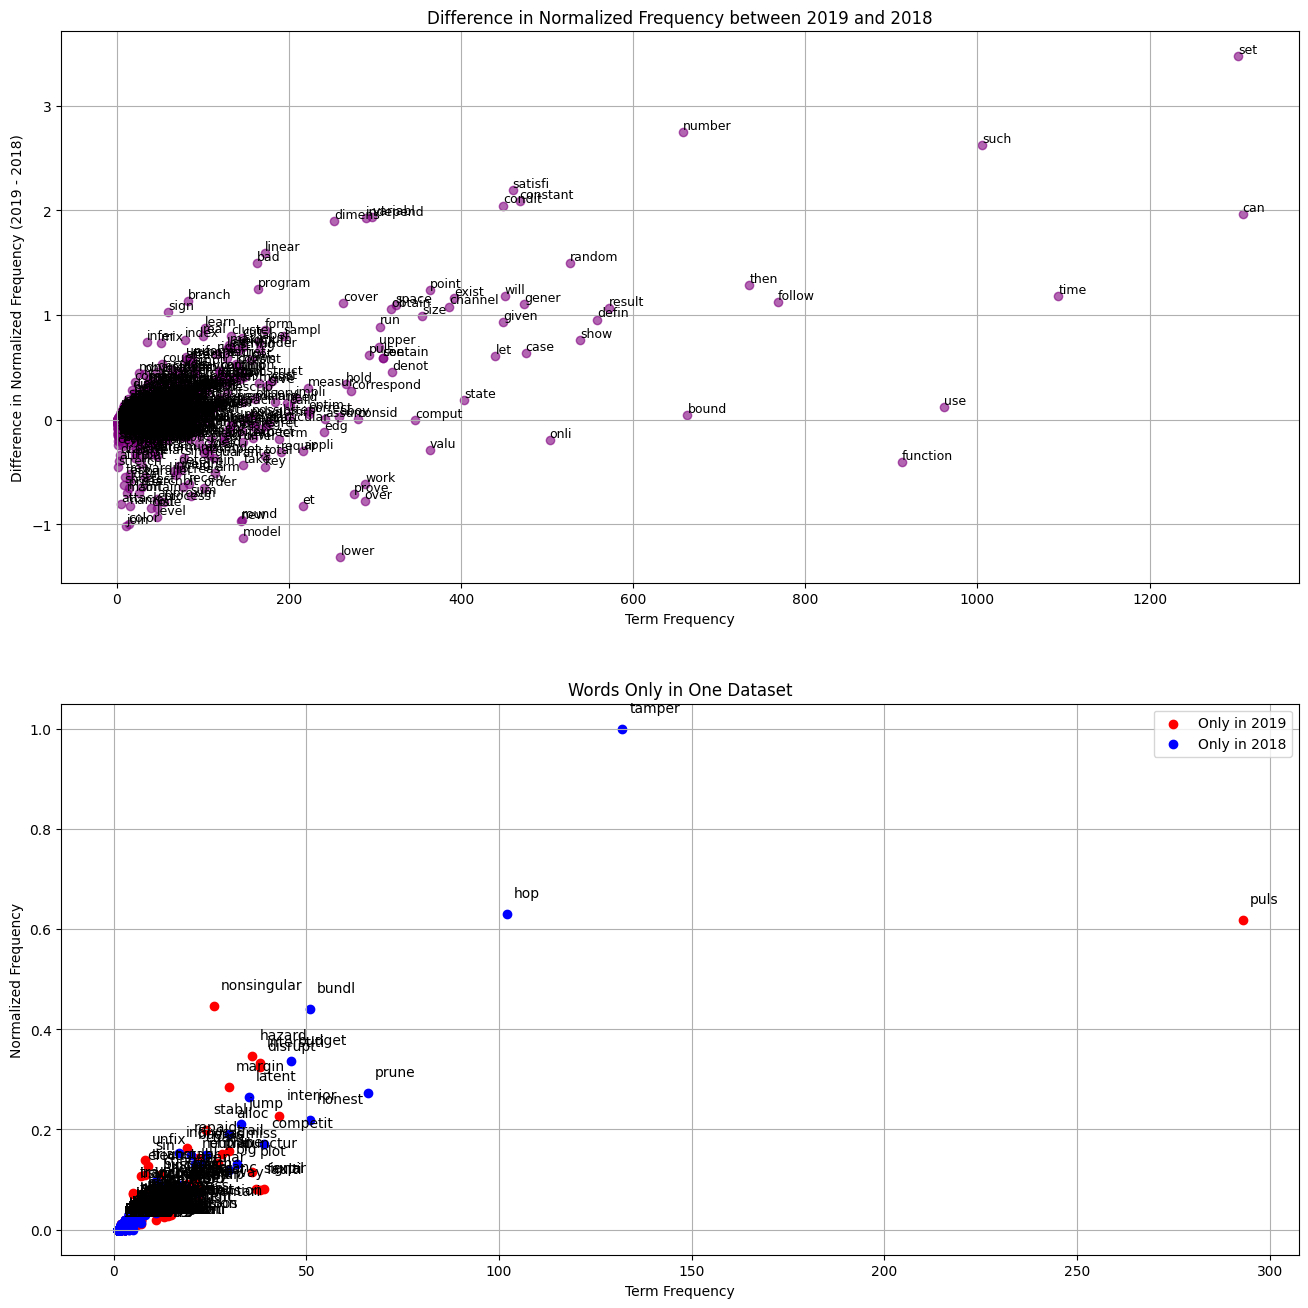

In [77]:
plot_combined_graphs(tf_2019, tf_2018, '2019', '2018')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

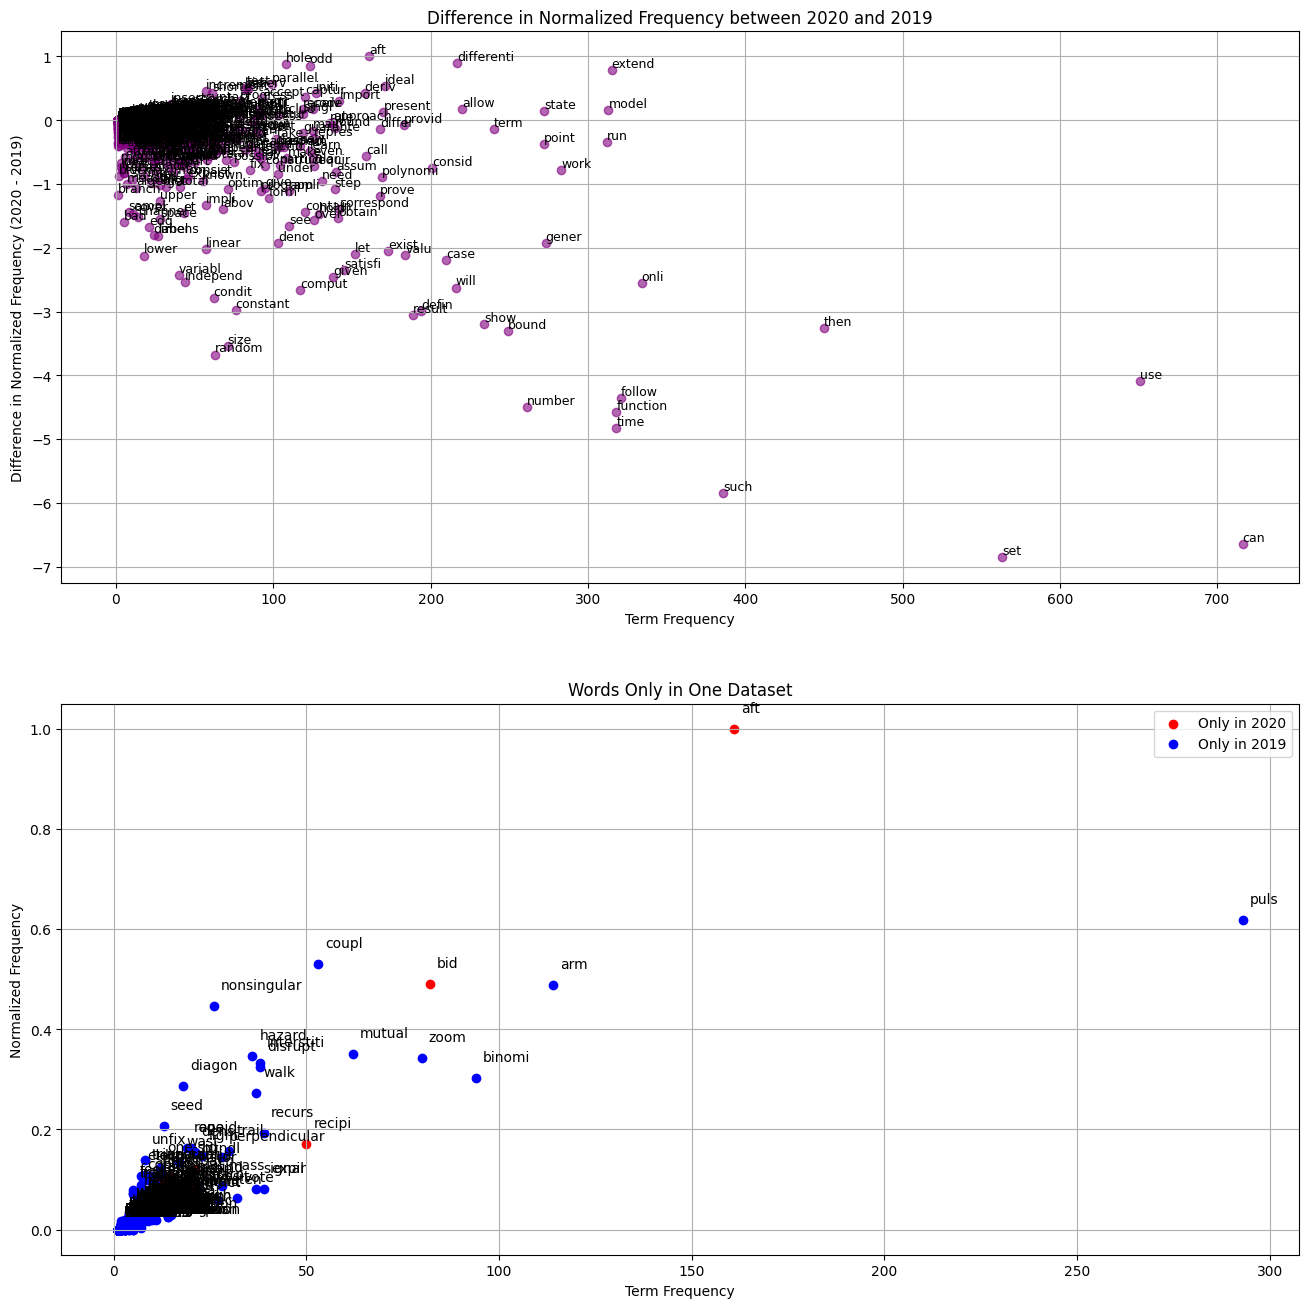

In [79]:
plot_combined_graphs(tf_2020, tf_2019, 2020, 2019)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

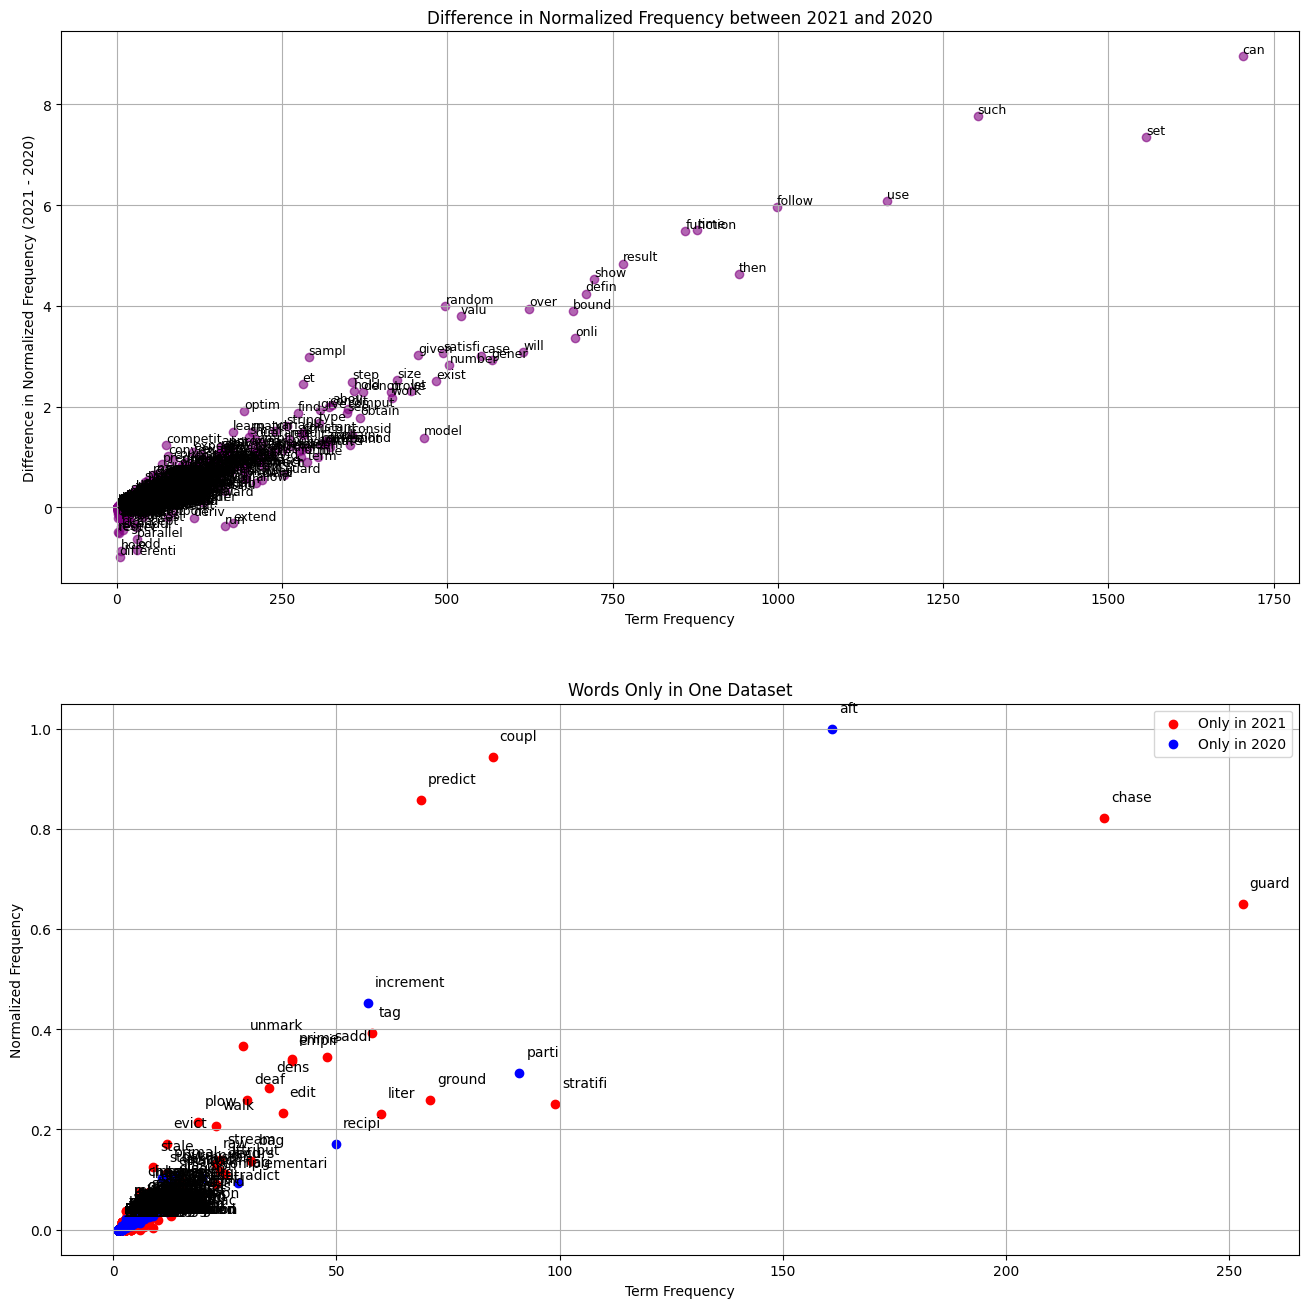

In [78]:
plot_combined_graphs(tf_2021, tf_2020, 2021, 2020)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

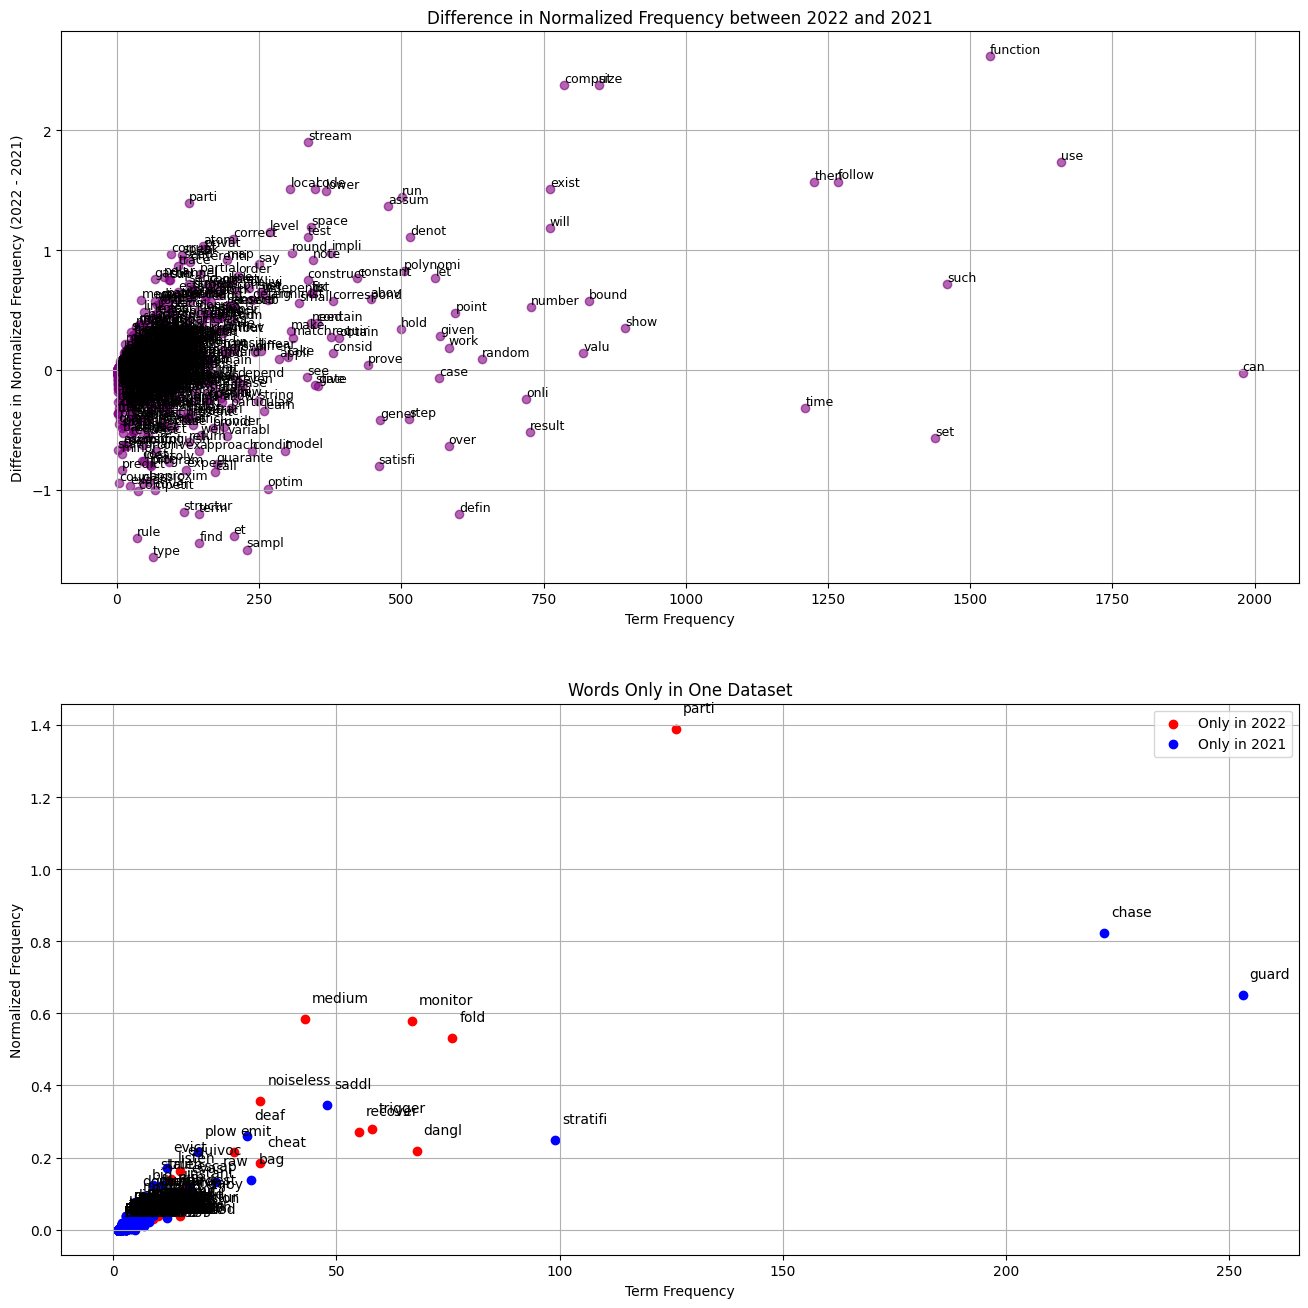

In [80]:
plot_combined_graphs(tf_2022, tf_2021, 2022, 2021)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

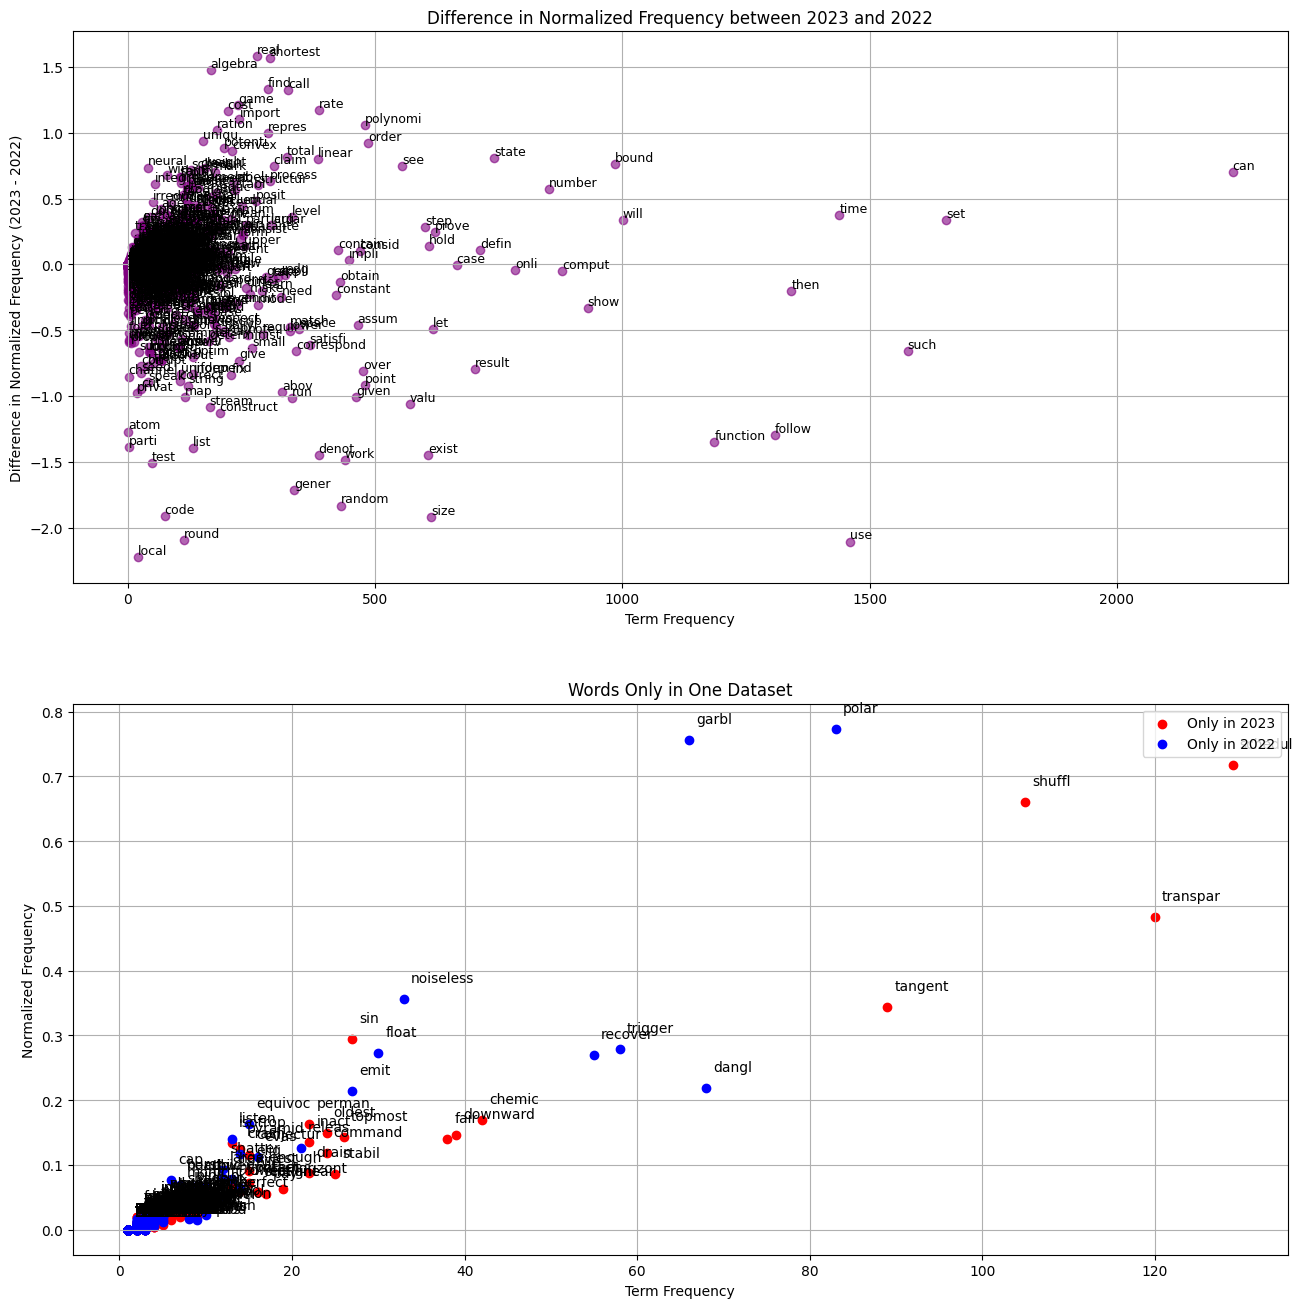

In [82]:
plot_combined_graphs(tf_2023, tf_2022, 2023, 2022)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

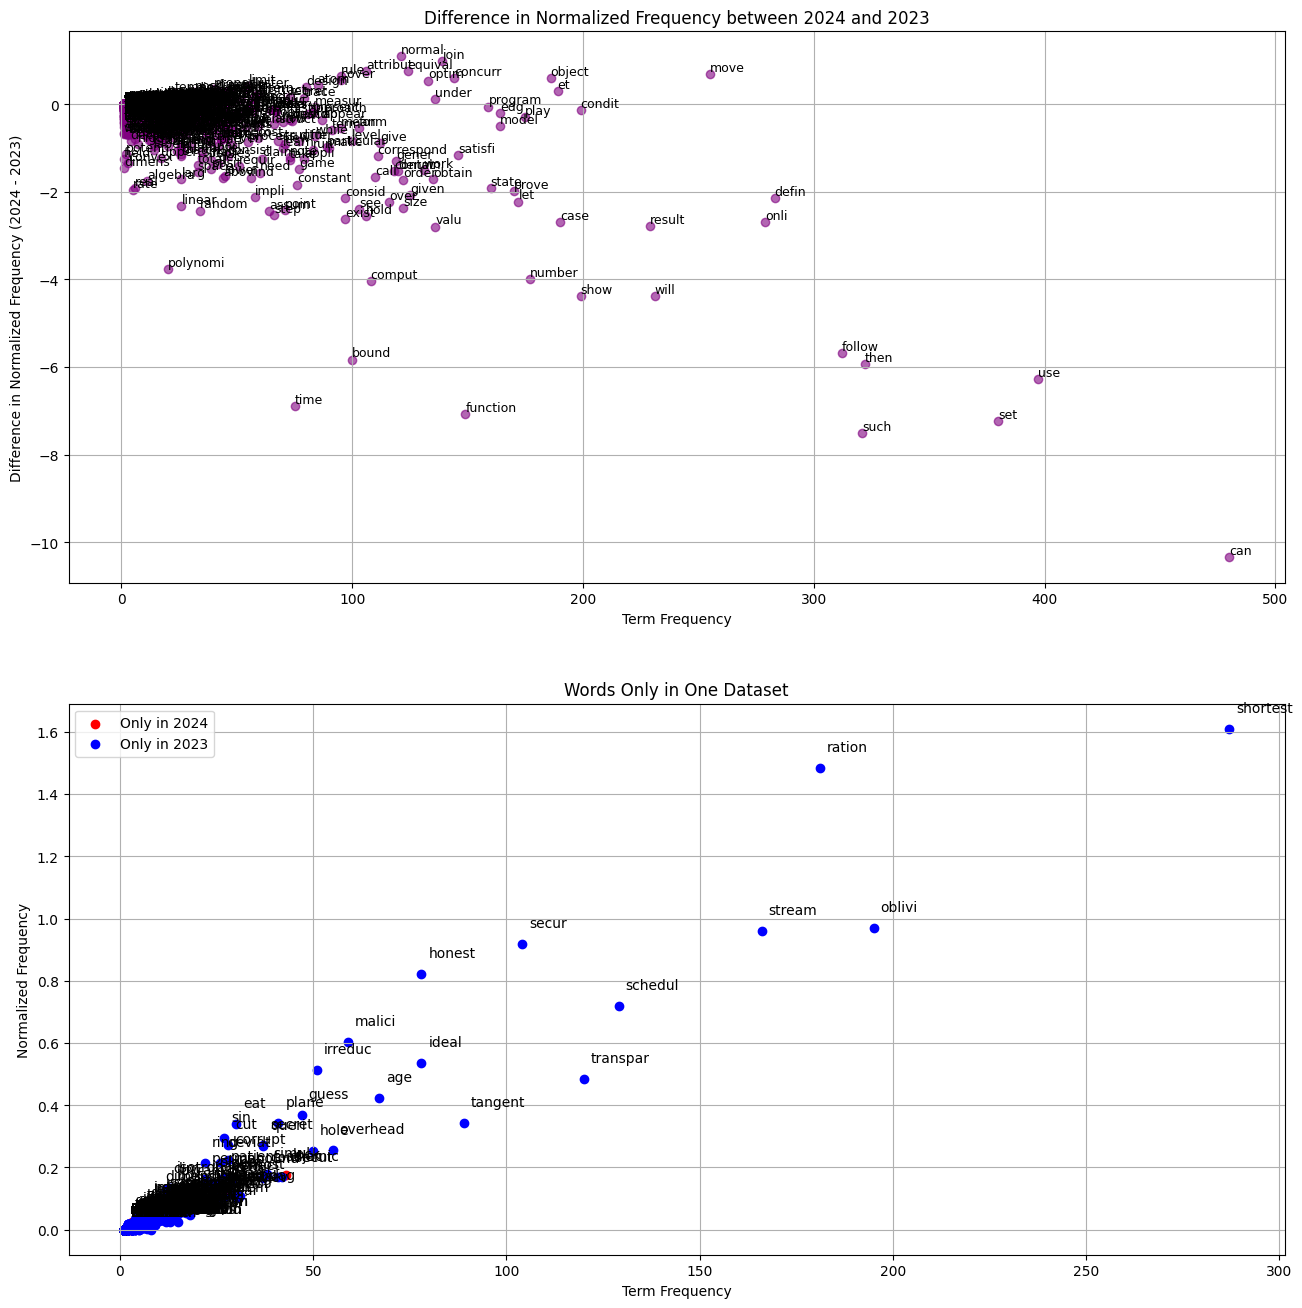

In [81]:
plot_combined_graphs(tf_2024, tf_2023, 2024, 2023)